# Google Play Store Apps - Data Analysis Project
## Notebook 5: Machine Learning and Predictive Modeling

### 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
df_apps = pd.read_csv('apps_cleaned.csv')

print(f"Data loaded: {df_apps.shape}")


Data loaded: (8196, 17)


### 2. Feature Engineering for ML

In [2]:
# Create a copy for ML
df_ml = df_apps.copy()

# Select relevant features
ml_features = ['Category', 'Rating', 'Reviews', 'Size', 'Installs',
               'Type', 'Price', 'Content Rating', 'Days_Since_Update']

df_ml = df_ml[ml_features].copy()

# Handle missing values
df_ml = df_ml.dropna()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Category', 'Type', 'Content Rating']

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[f'{col}_Encoded'] = le.fit_transform(df_ml[col])
    label_encoders[col] = le

print("=== Encoded Features ===")
print(df_ml.head())
print(f"\nFinal ML dataset shape: {df_ml.shape}")


=== Encoded Features ===
         Category  Rating   Reviews  Size    Installs  Type  Price  \
0  ART_AND_DESIGN     4.1     159.0  19.0     10000.0  Free    0.0   
1  ART_AND_DESIGN     3.9     967.0  14.0    500000.0  Free    0.0   
2  ART_AND_DESIGN     4.7   87510.0   8.7   5000000.0  Free    0.0   
3  ART_AND_DESIGN     4.5  215644.0  25.0  50000000.0  Free    0.0   
4  ART_AND_DESIGN     4.3     967.0   2.8    100000.0  Free    0.0   

  Content Rating  Days_Since_Update  Category_Encoded  Type_Encoded  \
0       Everyone                215                 0             0   
1       Everyone                207                 0             0   
2       Everyone                  9                 0             0   
3           Teen                 63                 0             0   
4       Everyone                 51                 0             0   

   Content Rating_Encoded  
0                       1  
1                       1  
2                       1  
3              

### 3. Problem 1: Predicting App Rating

In [3]:
# Prepare data for rating prediction
feature_cols = ['Category_Encoded', 'Reviews', 'Size', 'Installs',
                'Type_Encoded', 'Price', 'Content Rating_Encoded', 'Days_Since_Update']

X = df_ml[feature_cols]
y = df_ml['Rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== Rating Prediction Setup ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


=== Rating Prediction Setup ===
Training set: (5621, 8)
Test set: (1406, 8)


#### 3.1 Linear Regression Model

In [4]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression Results ===")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

# Feature importance
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Coefficients):")
print(feature_importance_lr)


=== Linear Regression Results ===
RMSE: 0.5694
R² Score: 0.0160

Feature Importance (Coefficients):
                  Feature  Coefficient
7       Days_Since_Update    -0.074044
4            Type_Encoded     0.042709
0        Category_Encoded    -0.032003
1                 Reviews     0.026374
5                   Price    -0.021794
6  Content Rating_Encoded     0.012163
3                Installs     0.009515
2                    Size     0.002491


#### 3.2 Random Forest Regressor

=== Random Forest Results ===
RMSE: 0.5277
R² Score: 0.1547

Feature Importance:
                  Feature  Importance
1                 Reviews    0.276074
7       Days_Since_Update    0.241089
2                    Size    0.198387
0        Category_Encoded    0.133008
3                Installs    0.102974
6  Content Rating_Encoded    0.022125
5                   Price    0.021665
4            Type_Encoded    0.004677


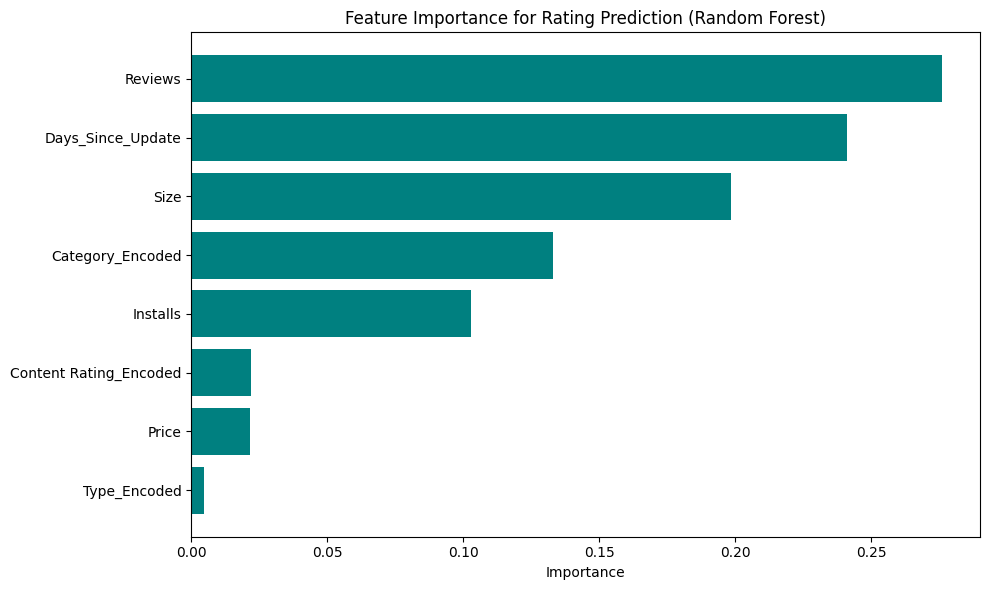

In [5]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Random Forest Results ===")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_rf)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance for Rating Prediction (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### 3.3 Compare Models

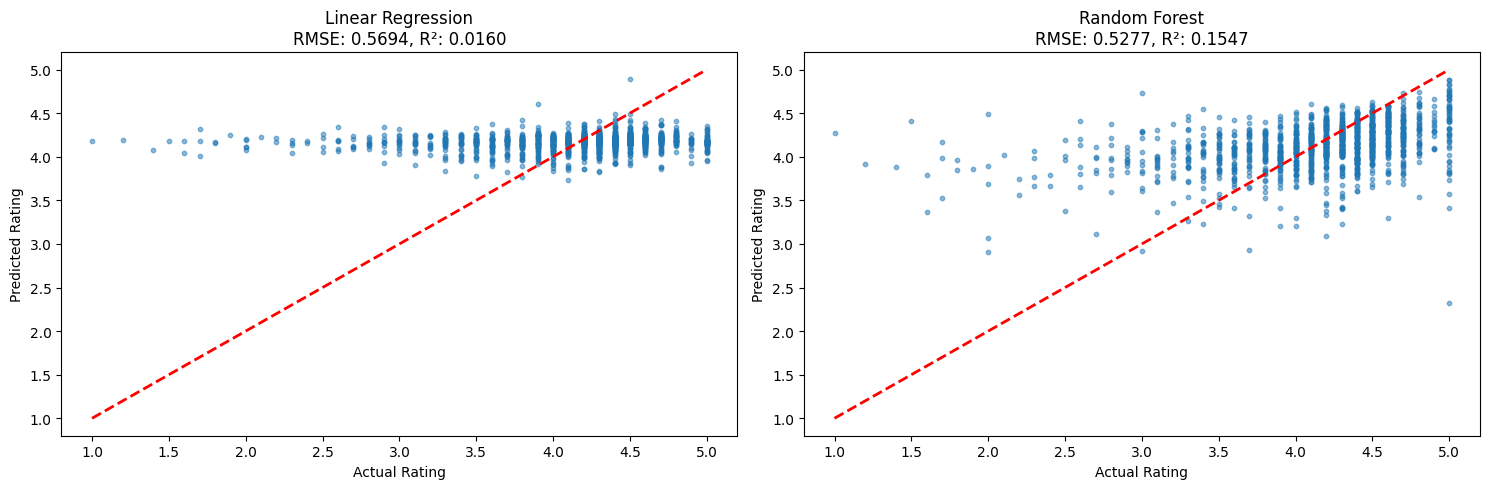


=== Model Comparison ===
               Model      RMSE  R² Score
0  Linear Regression  0.569386   0.01595
1      Random Forest  0.527730   0.15467


In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Linear Regression\nRMSE: {rmse_lr:.4f}, R²: {r2_lr:.4f}')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_title(f'Random Forest\nRMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}')

plt.tight_layout()
plt.show()

# Model comparison
print("\n=== Model Comparison ===")
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'R² Score': [r2_lr, r2_rf]
})
print(comparison_df)


### 4. Problem 2: Predicting App Success

In [7]:
# Define success (binary classification)
df_ml['Success'] = ((df_ml['Rating'] > 4.0) & (df_ml['Installs'] > 1000000)).astype(int)

# Prepare features
X_class = df_ml[feature_cols]
y_class = df_ml['Success']

# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print("=== Success Classification Setup ===")
print(f"Success rate in training: {y_train_c.mean()*100:.2f}%")
print(f"Success rate in test: {y_test_c.mean()*100:.2f}%")


=== Success Classification Setup ===
Success rate in training: 15.48%
Success rate in test: 15.43%


#### 4.1 Logistic Regression

=== Logistic Regression Results ===
              precision    recall  f1-score   support

Unsuccessful       0.93      0.99      0.96      1189
  Successful       0.92      0.61      0.73       217

    accuracy                           0.93      1406
   macro avg       0.92      0.80      0.85      1406
weighted avg       0.93      0.93      0.93      1406



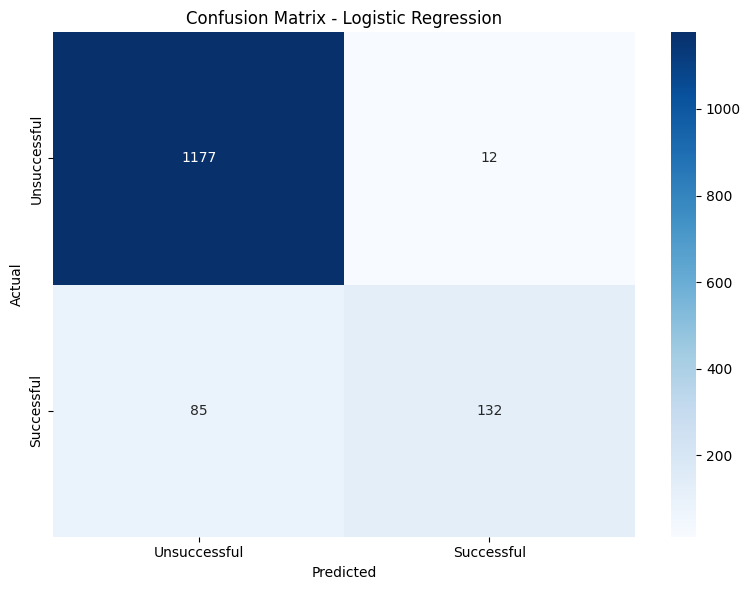

In [8]:
# Scale features
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

# Train Logistic Regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_c_scaled, y_train_c)

# Predictions
y_pred_log = log_model.predict(X_test_c_scaled)

# Evaluate
print("=== Logistic Regression Results ===")
print(classification_report(y_test_c, y_pred_log, target_names=['Unsuccessful', 'Successful']))

# Confusion Matrix
cm_log = confusion_matrix(y_test_c, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unsuccessful', 'Successful'],
            yticklabels=['Unsuccessful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()


#### 4.2 Random Forest Classifier

=== Random Forest Classifier Results ===
              precision    recall  f1-score   support

Unsuccessful       0.99      0.97      0.98      1189
  Successful       0.86      0.97      0.92       217

    accuracy                           0.97      1406
   macro avg       0.93      0.97      0.95      1406
weighted avg       0.97      0.97      0.97      1406



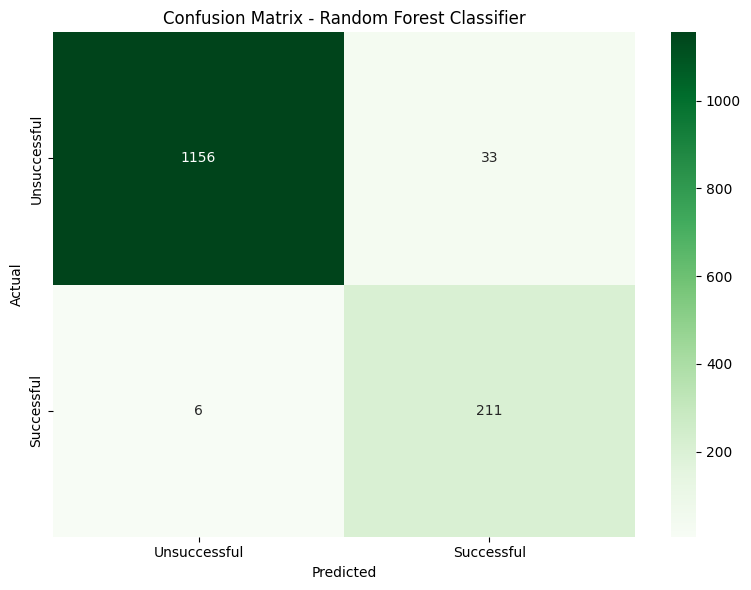


Feature Importance:
                  Feature  Importance
3                Installs    0.471842
1                 Reviews    0.364670
7       Days_Since_Update    0.059239
2                    Size    0.058045
0        Category_Encoded    0.031444
6  Content Rating_Encoded    0.009764
4            Type_Encoded    0.002601
5                   Price    0.002395


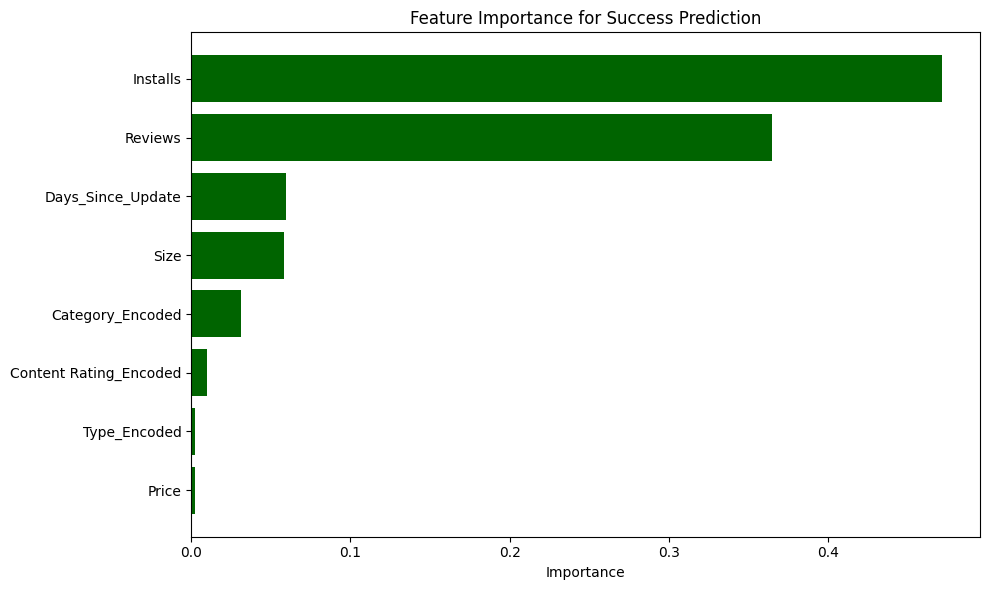

In [9]:
# Train Random Forest Classifier
rf_class = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_class.fit(X_train_c, y_train_c)

# Predictions
y_pred_rf_c = rf_class.predict(X_test_c)

# Evaluate
print("=== Random Forest Classifier Results ===")
print(classification_report(y_test_c, y_pred_rf_c, target_names=['Unsuccessful', 'Successful']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test_c, y_pred_rf_c)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Unsuccessful', 'Successful'],
            yticklabels=['Unsuccessful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_rf_c = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_class.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_rf_c)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf_c['Feature'], feature_importance_rf_c['Importance'], color='darkgreen')
plt.xlabel('Importance')
plt.title('Feature Importance for Success Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### 4.3 Decision Tree Classifier

In [10]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_c, y_train_c)

# Predictions
y_pred_dt = dt_model.predict(X_test_c)

# Evaluate
print("=== Decision Tree Results ===")
print(classification_report(y_test_c, y_pred_dt, target_names=['Unsuccessful', 'Successful']))


=== Decision Tree Results ===
              precision    recall  f1-score   support

Unsuccessful       0.99      0.97      0.98      1189
  Successful       0.85      0.94      0.89       217

    accuracy                           0.97      1406
   macro avg       0.92      0.96      0.94      1406
weighted avg       0.97      0.97      0.97      1406



### 5. Problem 3: Predicting Install Range

=== Install Range Prediction Results ===
              precision    recall  f1-score   support

        High       0.90      0.92      0.91       547
         Low       0.84      0.82      0.83       260
      Medium       0.85      0.84      0.85       556
   Very High       0.87      0.77      0.81        43

    accuracy                           0.87      1406
   macro avg       0.86      0.84      0.85      1406
weighted avg       0.87      0.87      0.87      1406



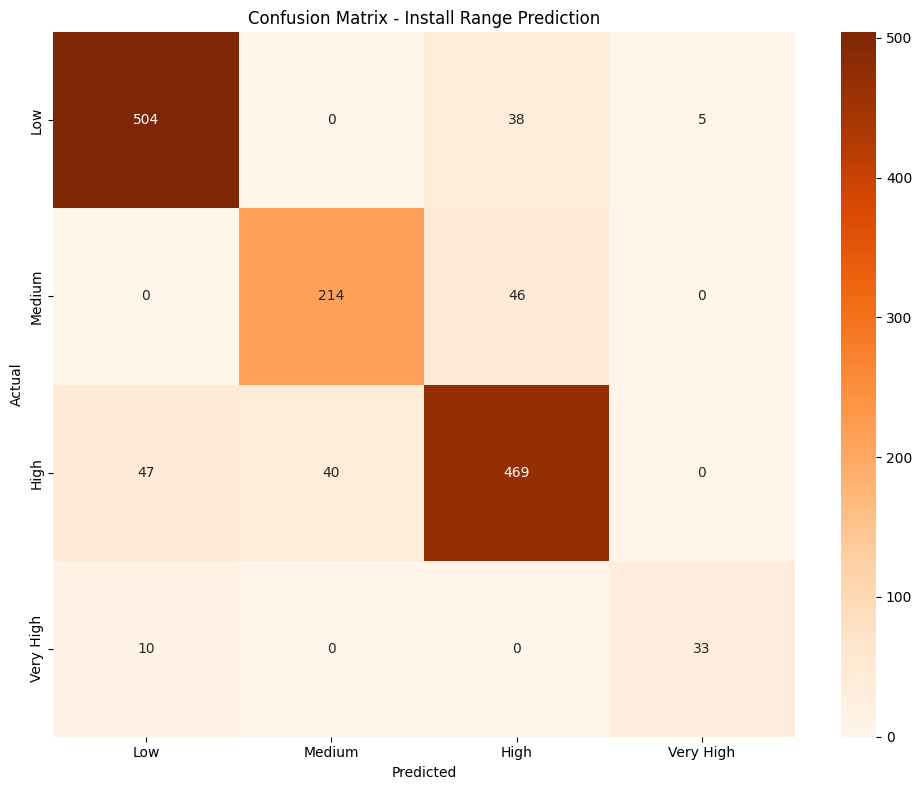

In [11]:
# Create install range categories
df_ml['Install_Category'] = pd.cut(df_ml['Installs'],
                                     bins=[0, 1000, 100000, 10000000, 1e10],
                                     labels=['Low', 'Medium', 'High', 'Very High'])

# Prepare features (excluding Installs)
feature_cols_installs = ['Category_Encoded', 'Rating', 'Reviews', 'Size',
                         'Type_Encoded', 'Price', 'Content Rating_Encoded', 'Days_Since_Update']

X_inst = df_ml[feature_cols_installs].dropna()
y_inst = df_ml.loc[X_inst.index, 'Install_Category']

# Split data
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_inst, y_inst, test_size=0.2, random_state=42, stratify=y_inst
)

# Train Random Forest
rf_inst = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_inst.fit(X_train_i, y_train_i)

# Predictions
y_pred_inst = rf_inst.predict(X_test_i)

# Evaluate
print("=== Install Range Prediction Results ===")
print(classification_report(y_test_i, y_pred_inst))

# Confusion Matrix
cm_inst = confusion_matrix(y_test_i, y_pred_inst)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_inst, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Install Range Prediction')
plt.tight_layout()
plt.show()


### 6. Cross-Validation Analysis

In [12]:
# Cross-validation for rating prediction
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print("=== Cross-Validation Results (Rating Prediction) ===")
print(f"CV R² Scores: {cv_scores_rf}")
print(f"Mean R² Score: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Cross-validation for success classification
cv_scores_rf_c = cross_val_score(rf_class, X_class, y_class, cv=5, scoring='accuracy')

print("\n=== Cross-Validation Results (Success Classification) ===")
print(f"CV Accuracy Scores: {cv_scores_rf_c}")
print(f"Mean Accuracy: {cv_scores_rf_c.mean():.4f} (+/- {cv_scores_rf_c.std() * 2:.4f})")


=== Cross-Validation Results (Rating Prediction) ===
CV R² Scores: [-0.04498541  0.025027    0.09035904  0.05724633  0.06486044]
Mean R² Score: 0.0385 (+/- 0.0933)

=== Cross-Validation Results (Success Classification) ===
CV Accuracy Scores: [0.96301565 0.94238976 0.96085409 0.98078292 0.96797153]
Mean Accuracy: 0.9630 (+/- 0.0248)


### 7. Model Performance Summary

In [13]:
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

print("\n1. RATING PREDICTION:")
print(f"   • Linear Regression - RMSE: {rmse_lr:.4f}, R²: {r2_lr:.4f}")
print(f"   • Random Forest     - RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

print("\n2. SUCCESS CLASSIFICATION:")
from sklearn.metrics import accuracy_score
print(f"   • Logistic Regression - Accuracy: {accuracy_score(y_test_c, y_pred_log):.4f}")
print(f"   • Random Forest      - Accuracy: {accuracy_score(y_test_c, y_pred_rf_c):.4f}")
print(f"   • Decision Tree      - Accuracy: {accuracy_score(y_test_c, y_pred_dt):.4f}")

print("\n3. INSTALL RANGE PREDICTION:")
print(f"   • Random Forest - Accuracy: {accuracy_score(y_test_i, y_pred_inst):.4f}")

print("\n4. TOP PREDICTIVE FEATURES:")
print(f"   For Rating:")
for idx, row in feature_importance_rf.head(3).iterrows():
    print(f"      • {row['Feature']}: {row['Importance']:.4f}")

print(f"\n   For Success:")
for idx, row in feature_importance_rf_c.head(3).iterrows():
    print(f"      • {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*70)



MODEL PERFORMANCE SUMMARY

1. RATING PREDICTION:
   • Linear Regression - RMSE: 0.5694, R²: 0.0160
   • Random Forest     - RMSE: 0.5277, R²: 0.1547

2. SUCCESS CLASSIFICATION:
   • Logistic Regression - Accuracy: 0.9310
   • Random Forest      - Accuracy: 0.9723
   • Decision Tree      - Accuracy: 0.9651

3. INSTALL RANGE PREDICTION:
   • Random Forest - Accuracy: 0.8677

4. TOP PREDICTIVE FEATURES:
   For Rating:
      • Reviews: 0.2761
      • Days_Since_Update: 0.2411
      • Size: 0.1984

   For Success:
      • Installs: 0.4718
      • Reviews: 0.3647
      • Days_Since_Update: 0.0592



In [16]:
print(feature_cols_installs)


['Category_Encoded', 'Rating', 'Reviews', 'Size', 'Type_Encoded', 'Price', 'Content Rating_Encoded', 'Days_Since_Update']


### 8. Practical Predictions

In [19]:
print("\n=== EXAMPLE PREDICTION ===")

# Create a sample app (median-like values)
sample_app = pd.DataFrame({
    'Category_Encoded': [df_ml['Category_Encoded'].median()],
    'Reviews': [500],
    'Size': [20],
    'Installs': [100000],
    'Type_Encoded': [0],  # Free
    'Price': [0],
    'Content Rating_Encoded': [0],  # Everyone
    'Days_Since_Update': [30]
})

# --- 1. Rating Prediction (rf_model) ---
sample_rating_input = sample_app[feature_cols].copy()

# Apply scaler (rating model uses scaled features)
sample_rating_scaled = scaler.transform(sample_rating_input)

predicted_rating = rf_model.predict(sample_rating_input)[0]
print(f"\nPredicted Rating: {predicted_rating:.2f}")

# --- 2. Success Prediction ---
sample_success_input = sample_app[feature_cols].copy()
sample_success_scaled = scaler.transform(sample_success_input)

predicted_success_prob = rf_class.predict_proba(sample_success_input)[0]
print(f"Success Probability: {predicted_success_prob[1]*100:.1f}%")

# --- 3. Install Range Prediction (rf_inst) ---
# This model REQUIRES 'Rating' as input feature
sample_install_input = sample_app.copy()
sample_install_input['Rating'] = predicted_rating  # Add predicted rating

# Keep only install model features
sample_install_input = sample_install_input[feature_cols_installs]

predicted_install_range = rf_inst.predict(sample_install_input)[0]
print(f"Predicted Install Range: {predicted_install_range}")



=== EXAMPLE PREDICTION ===

Predicted Rating: 3.71
Success Probability: 0.0%
Predicted Install Range: Medium


### 9. Save Models

In [20]:
import pickle

# Save models
models_to_save = {
    'rating_predictor': rf_model,
    'success_classifier': rf_class,
    'install_predictor': rf_inst,
    'scaler': scaler,
    'label_encoders': label_encoders
}

for name, model in models_to_save.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

print("\n✓ Models saved successfully!")



✓ Models saved successfully!


In [21]:
import gradio as gr
import pandas as pd
import pickle

# Load saved models
with open("rating_predictor.pkl", "rb") as f:
    rating_model = pickle.load(f)

with open("success_classifier.pkl", "rb") as f:
    success_model = pickle.load(f)

with open("install_predictor.pkl", "rb") as f:
    install_model = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Features list
feature_cols = ['Category_Encoded', 'Reviews', 'Size', 'Installs',
                'Type_Encoded', 'Price', 'Content Rating_Encoded', 'Days_Since_Update']

feature_cols_installs = ['Category_Encoded', 'Rating', 'Reviews', 'Size',
                         'Type_Encoded', 'Price', 'Content Rating_Encoded', 'Days_Since_Update']


# -----------------------------
# 🔥 Prediction Function
# -----------------------------
def predict_app(category, reviews, size, installs, app_type, price, content_rating, days_update):
    # Encode categorical values
    category_encoded = label_encoders["Category"].transform([category])[0]
    type_encoded = label_encoders["Type"].transform([app_type])[0]
    cr_encoded = label_encoders["Content Rating"].transform([content_rating])[0]

    # Make input DF
    input_df = pd.DataFrame({
        "Category_Encoded": [category_encoded],
        "Reviews": [reviews],
        "Size": [size],
        "Installs": [installs],
        "Type_Encoded": [type_encoded],
        "Price": [price],
        "Content Rating_Encoded": [cr_encoded],
        "Days_Since_Update": [days_update]
    })

    # 🔹 Rating Prediction
    rating_pred = rating_model.predict(input_df)[0]

    # 🔹 Success Prediction
    success_prob = success_model.predict_proba(input_df)[0][1] * 100

    # 🔹 Install Range Prediction
    input_inst = input_df.copy()
    input_inst["Rating"] = rating_pred  # model requires rating as feature
    install_range = install_model.predict(input_inst[feature_cols_installs])[0]

    return (
        round(rating_pred, 2),
        f"{success_prob:.2f} %",
        str(install_range)
    )


# -----------------------------
# 🎨 GRADIO UI
# -----------------------------
def build_ui():
    with gr.Blocks(theme=gr.themes.Soft(primary_hue="amber", secondary_hue="gray")) as demo:
        gr.Markdown("# 📱 Google Play App Predictor\n### Predict Rating, Success Probability & Install Range")

        with gr.Row():
            category = gr.Dropdown(
                choices=label_encoders["Category"].classes_.tolist(),
                label="Category"
            )
            content_rating = gr.Dropdown(
                choices=label_encoders["Content Rating"].classes_.tolist(),
                label="Content Rating"
            )

        with gr.Row():
            app_type = gr.Dropdown(
                choices=label_encoders["Type"].classes_.tolist(),
                label="App Type (Free/Paid)"
            )
            price = gr.Number(label="Price", value=0)

        with gr.Row():
            reviews = gr.Number(label="Reviews Count", value=500)
            installs = gr.Number(label="Installs", value=100000)

        with gr.Row():
            size = gr.Number(label="App Size (MB)", value=20)
            days_update = gr.Number(label="Days Since Last Update", value=30)

        run_button = gr.Button("🔮 Predict")

        rating_out = gr.Number(label="Predicted Rating")
        success_out = gr.Textbox(label="Success Probability")
        install_out = gr.Textbox(label="Install Range")

        run_button.click(
            predict_app,
            inputs=[category, reviews, size, installs, app_type, price,
                    content_rating, days_update],
            outputs=[rating_out, success_out, install_out]
        )

    return demo


app = build_ui()

if __name__ == "__main__":
    app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e6b50a57fb1d6f83d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
